In [5]:
# -*- coding: utf-8 -*-
"""
Run the code as 
python3 scikit_kfold_training.py'rf' 'multi'

"""

import os,sys
import numpy as np
from sklearn import svm
n_input_pars=8
n_output_pars=4
from sklearn.neighbors import KNeighborsClassifier
import copy
from astropy.table import Table
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import StratifiedKFold
from matplotlib.backends.backend_pdf import PdfPages
from numpy import interp
import json
import pickle

In [6]:
# Define your type of training, 'rf', 'knn', 'svc', or 'mlp'
short='rf' #sys.argv[1]
try:
    training_type=sys.argv[2]  # Training type decides if you want to train the model at multiple training sample size. 'multi' will do so. 
except:
    training_type='single'

# Calculate the accuracy of the for classifications with this function
def calculate_accuracy_arr(test):
    n_all=len(test)
    ind_sf=np.where(test==1)
    ind_comp=np.where(test==2)
    ind_AGN=np.where(test==3)
    ind_liner=np.where(test==4)
    if len(test)==0:
        accuracy=[0.,0.,0.,0.]
    else:
        accuracy=[float(len(ind_sf[0]))/n_all,float(len(ind_comp[0]))/n_all,float(len(ind_AGN[0]))/n_all,float(len(ind_liner[0]))/n_all]
    return accuracy

In [7]:
# Sort through the data to only get 'real' data, no noise. For example the S/N must be larger than 3 
data = Table.read('data_matched_step2_newz_sm.csv',format='ascii.csv',header_start=0,data_start=1)
ind1=np.where(np.array(data['o3']/data['o3_err']) >3)
ind2=np.where(np.array((data['o21']+data['o22'])/np.sqrt(data['o21_err']**2+data['o22_err']**2)) >3)
ind3=np.where(np.array(data['hb']/data['hb_err']) >3)
ind4=np.where(np.array(data['ha']/data['ha_err']) >3)
ind5=np.where(np.array(data['s21']/data['s21_err']) >3)
ind6=np.where(np.array(data['n2']/data['n2_err']) >3)
ind7=np.where(np.array(data['sigma_o3']/data['sigma_o3_err']) >3)
ind8=np.where(np.array(data['VDISP'])>0.)
ind9=np.where(np.array(data['mag_u'])>10.)
ind10=np.where(np.array(data['flux_w1'])>0.)


ind_g=np.where(np.array(data['flux_g']) >0.)
ind_r=np.where(np.array(data['flux_r']) >0.)
ind_z=np.where(np.array(data['flux_z']) >0.)

# Calculate absolute magnitude (I think)
data['mag_g'][ind_g]=22.5-2.5*np.log10(data['flux_g'][ind_g])
data['mag_r'][ind_r]=22.5-2.5*np.log10(data['flux_r'][ind_r])
data['mag_z'][ind_z]=22.5-2.5*np.log10(data['flux_z'][ind_z])

# Sort through these indices
ind=np.array(list(set(ind1[0]) & set(ind1[0]) &set(ind2[0]) & set(ind3[0]) & set(ind4[0]) & set(ind5[0]) & set(ind6[0]) & set(ind7[0]) & set(ind8[0])))# & set(ind9[0])& set(ind10[0]) ))
n_source=len(ind)

# Split into training and test set
n_split=int(n_source*0.7)
ind_train=ind[0:n_split]
ind_test=ind[n_split:]
n_train=len(ind_train)
n_test=len(ind_test)
type_arr=np.zeros(len(ind))
type_arr=type_arr-999

# Get/define the 8 input features
z=np.array(data['z'][ind])
O2_index=np.log10((data['o21'][ind]+data['o22'][ind])/data['hb'][ind])
O3_index=np.log10(data['o3'][ind]/data['hb'][ind])
N2_index=np.log10(data['n2'][ind]/data['ha'][ind])
S2_index=np.log10((data['s21'][ind]+data['s22'][ind])/data['ha'][ind])
sigma_o3=np.log10(data['sigma_o3'][ind])
sigma_star=np.log10(data['VDISP'][ind])
u_g=data['mag_u'][ind]-data['mag_g'][ind]
g_r=data['mag_g'][ind]-data['mag_r'][ind]
r_i=data['mag_r'][ind]-data['mag_i'][ind]
i_z=data['mag_i'][ind]-data['mag_z'][ind]

# Correct the redshift
z_w1=data['mag_z'][ind]-(22.5-2.5*np.log10(data['flux_w1'][ind]))

# Classify the galaxies into one of the four classes: star-forming galaxies, composite galaxies, 
# active galactic nuclei (AGNs), or low-ionization nuclear emission regions (LINERs) 
ind_sf1=np.where(O3_index <= (0.61/(N2_index-0.05)+1.3))
ind_sf2=np.where( N2_index < 0.)
ind_sf=np.array(list(set(ind_sf1[0]) & set(ind_sf2[0])))

ind_AGN1=np.where(O3_index > (0.61/(N2_index-0.47)+1.19))
ind_AGN2=np.where(N2_index >= 0.)
ind_AGN3=np.where(O3_index > 1.89*S2_index+0.76)
ind_AGN=np.array(list((set(ind_AGN1[0]) | set(ind_AGN2[0])) & set(ind_AGN3[0])))


ind_liner1=np.where(O3_index > (0.61/(N2_index-0.47)+1.19))
ind_liner2=np.where(O3_index <= 1.89*S2_index+0.76)
ind_liner=np.array(list(set(ind_liner1[0]) & set(ind_liner2[0])))


ind_comp1=np.where(O3_index < (0.61/(N2_index-0.47)+1.19))
ind_comp2=np.where(O3_index > (0.61/(N2_index-0.05)+1.3))
ind_comp=np.array(list(set(ind_comp1[0]) & set(ind_comp2[0])))

type_arr[ind_sf]=1
type_arr[ind_comp]=2
type_arr[ind_AGN]=3
type_arr[ind_liner]=4

# Making the training classifications
type_arr_train=np.zeros(len(ind_train))
type_arr_train=type_arr_train-999

# Get/define the features for the training
O2_index_train=np.log10((data['o21'][ind_train]+data['o22'][ind_train])/data['hb'][ind_train])
O3_index_train=np.log10(data['o3'][ind_train]/data['hb'][ind_train])
N2_index_train=np.log10(data['n2'][ind_train]/data['ha'][ind_train])
S2_index_train=np.log10((data['s21'][ind_train]+data['s22'][ind_train])/data['ha'][ind_train])
sigma_o3_train=np.log10(data['sigma_o3'][ind_train])
sigma_star_train=np.log10(data['VDISP'][ind_train])
u_g_train=data['mag_u'][ind_train]-data['mag_g'][ind_train]
g_r_train=data['mag_g'][ind_train]-data['mag_r'][ind_train]
r_i_train=data['mag_r'][ind_train]-data['mag_i'][ind_train]
i_z_train=data['mag_i'][ind_train]-data['mag_z'][ind_train]
z_w1_train=data['mag_z'][ind_train]-(22.5-np.log10(data['flux_w1'][ind_train]))
sm_train=data['sm'][ind_train]

# Classification 
ind_sf1_train=np.where(O3_index_train <= (0.61/(N2_index_train-0.05)+1.3))
ind_sf2_train=np.where( N2_index_train < 0.)
ind_sf_train=np.array(list(set(ind_sf1_train[0]) & set(ind_sf2_train[0])))

ind_AGN1_train=np.where(O3_index_train > (0.61/(N2_index_train-0.47)+1.19))
ind_AGN2_train=np.where(N2_index_train >= 0.)
ind_AGN3_train=np.where(O3_index_train > 1.89*S2_index_train+0.76)
ind_AGN_train=np.array(list(set(ind_AGN1_train[0]) | set(ind_AGN2_train[0]) & set(ind_AGN3_train[0])))


ind_liner1_train=np.where(O3_index_train > (0.61/(N2_index_train-0.47)+1.19)) 
ind_liner2_train=np.where(O3_index_train <= 1.89*S2_index_train+0.76)
ind_liner_train=np.array(list(set(ind_liner1_train[0]) & set(ind_liner2_train[0])))


ind_comp1_train=np.where(O3_index_train < (0.61/(N2_index_train-0.47)+1.19))
ind_comp2_train=np.where(O3_index_train > (0.61/(N2_index_train-0.05)+1.3))
ind_comp_train=np.array(list(set(ind_comp1_train[0]) & set(ind_comp2_train[0])))


type_arr_train[ind_sf_train]=1
type_arr_train[ind_comp_train]=2
type_arr_train[ind_AGN_train]=3
type_arr_train[ind_liner_train]=4

# Testing features + classifications
type_arr_test=np.zeros(len(ind_test))
type_arr_test=type_arr_test-999

O2_index_test=np.log10((data['o21'][ind_test]+data['o22'][ind_test])/data['hb'][ind_test])
O3_index_test=np.log10(data['o3'][ind_test]/data['hb'][ind_test])
N2_index_test=np.log10(data['n2'][ind_test]/data['ha'][ind_test])
S2_index_test=np.log10((data['s21'][ind_test]+data['s22'][ind_test])/data['ha'][ind_test])
sigma_o3_test=np.log10(data['sigma_o3'][ind_test])
sigma_star_test=np.log10(data['VDISP'][ind_test])
u_g_test=data['mag_u'][ind_test]-data['mag_g'][ind_test]
g_r_test=data['mag_g'][ind_test]-data['mag_r'][ind_test]
r_i_test=data['mag_r'][ind_test]-data['mag_i'][ind_test]
i_z_test=data['mag_i'][ind_test]-data['mag_z'][ind_test]
z_w1_test=data['mag_z'][ind_test]-(22.5-np.log10(data['flux_w1'][ind_test]))
sm_test=data['sm'][ind_test]

ind_sf1_test=np.where(O3_index_test <= (0.61/(N2_index_test-0.05)+1.3))
ind_sf2_test=np.where( N2_index_test < 0.)
ind_sf_test=np.array(list(set(ind_sf1_test[0]) & set(ind_sf2_test[0])))

ind_AGN1_test=np.where(O3_index_test > (0.61/(N2_index_test-0.47)+1.19))
ind_AGN2_test=np.where(N2_index_test >= 0.)
ind_AGN3_test=np.where(O3_index_test > 1.89*S2_index_test+0.76)
ind_AGN_test=np.array(list(set(ind_AGN1_test[0]) | set(ind_AGN2_test[0]) & set(ind_AGN3_test[0])))


ind_liner1_test=np.where(O3_index_test > (0.61/(N2_index_test-0.47)+1.19))
ind_liner2_test=np.where(O3_index_test <= 1.89*S2_index_test+0.76)
ind_liner_test=np.array(list(set(ind_liner1_test[0]) & set(ind_liner2_test[0])))


ind_comp1_test=np.where(O3_index_test < (0.61/(N2_index_test-0.47)+1.19))
ind_comp2_test=np.where(O3_index_test > (0.61/(N2_index_test-0.05)+1.3))
ind_comp_test=np.array(list(set(ind_comp1_test[0]) & set(ind_comp2_test[0])))

type_arr_test[ind_sf_test]=1
type_arr_test[ind_comp_test]=2
type_arr_test[ind_AGN_test]=3
type_arr_test[ind_liner_test]=4

ind_this=ind_sf

# Making a catalog of the different classifications, not entirely sure why yet
os.system('rm catalog_lowz*.dat')
f=open('catalog_lowz_sf.dat','w')
f.write('# PLATE   MJD     FIBERID   Z   \n')
for i in range(len(ind_this)):
    indind=ind[ind_this[i]]
    outline=str(data['PLATE'][indind])+'   '+str(data['MJD'][indind])+'     '+str(data['FIBERID'][indind])+'     '+str(data['z'][indind])+'\n'
    f.write(outline)
f.close()

ind_this=ind_comp
f=open('catalog_lowz_comp.dat','w')
f.write('# PLATE   MJD     FIBERID   Z   \n')
for i in range(len(ind_this)):
    indind=ind[ind_this[i]]
    outline=str(data['PLATE'][indind])+'   '+str(data['MJD'][indind])+'     '+str(data['FIBERID'][indind])+'     '+str(data['z'][indind])+'\n'
    f.write(outline)
f.close()

ind_this=ind_AGN
f=open('catalog_lowz_AGN.dat','w')
f.write('# PLATE   MJD     FIBERID   Z   \n')
for i in range(len(ind_this)):
    indind=ind[ind_this[i]]
    outline=str(data['PLATE'][indind])+'   '+str(data['MJD'][indind])+'     '+str(data['FIBERID'][indind])+'     '+str(data['z'][indind])+'\n'
    f.write(outline)
f.close()

ind_this=ind_liner
f=open('catalog_lowz_liner.dat','w')
f.write('# PLATE   MJD     FIBERID   Z   \n')
for i in range(len(ind_this)):
    indind=ind_this[i]
    outline=str(data['PLATE'][indind])+'   '+str(data['MJD'][indind])+'     '+str(data['FIBERID'][indind])+'     '+str(data['z'][indind])+'\n'
    f.write(outline)
f.close()

markersize=1

C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2767476754.py:9: RuntimeWarning: divide by zero encountered in divide
  ind7=np.where(np.array(data['sigma_o3']/data['sigma_o3_err']) >3)
C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2767476754.py:9: RuntimeWarning: invalid value encountered in divide
  ind7=np.where(np.array(data['sigma_o3']/data['sigma_o3_err']) >3)
C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2767476754.py:42: RuntimeWarning: invalid value encountered in log10
  S2_index=np.log10((data['s21'][ind]+data['s22'][ind])/data['ha'][ind])
C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2767476754.py:51: RuntimeWarning: divide by zero encountered in log10
  z_w1=data['mag_z'][ind]-(22.5-2.5*np.log10(data['flux_w1'][ind]))
C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2767476754.py:51: RuntimeWarning: invalid value encountered in log10
  z_w1=data['mag_z'][ind]-(22.5-2.5*np.log10(data['flux_w1'][ind]))
C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\27

In [8]:
#######################################################################
### Learning Code starts here #####
######################################
# Number of samples
n_round=10000

# If you use multiple batches, then divide these into 5 batches, otherwise keep all 10 000
if training_type=='multi':
    mark_points=(1+np.arange(50))*0.02*float(n_round)
else:
    mark_points=np.array([n_round])
mark_points=mark_points.astype(int)
n_mark_points=len(mark_points)
accuracy_sf=np.zeros((n_mark_points,4))
accuracy_comp=np.zeros((n_mark_points,4))
accuracy_liner=np.zeros((n_mark_points,4))
accuracy_AGN=np.zeros((n_mark_points,4))
accuracy_overall=np.zeros((n_mark_points,4))
completeness_sf=np.zeros(n_mark_points)
completeness_comp=np.zeros(n_mark_points)
completeness_liner=np.zeros(n_mark_points)
completeness_AGN=np.zeros(n_mark_points)

median_sf=[]
median_comp=[]
median_AGN=[]
median_liner=[]

# Your 8 input features
var_arr=['O3_index','O2_index','sigma_star','sigma_o3','u_g','g_r','r_i','i_z']

# Calculate normalized median features
for var in var_arr:
    cmd='t=(np.median('+var+'[ind_sf])-np.percentile('+var+',5))/(np.percentile('+var+',95)-np.percentile('+var+',5))'
    exec(cmd)
    median_sf.append(float(t))
for var in var_arr:
    cmd='t=(np.median('+var+'[ind_comp])-np.percentile('+var+',5))/(np.percentile('+var+',95)-np.percentile('+var+',5))'
    exec(cmd)
    median_comp.append(float(t))
for var in var_arr:
    cmd='t=(np.median('+var+'[ind_AGN])-np.percentile('+var+',5))/(np.percentile('+var+',95)-np.percentile('+var+',5))'
    exec(cmd)
    median_AGN.append(float(t))
for var in var_arr:
    cmd='t=(np.median('+var+'[ind_liner])-np.percentile('+var+',5))/(np.percentile('+var+',95)-np.percentile('+var+',5))'
    exec(cmd)
    median_liner.append(float(t))

axprops = dict(xticks=[], yticks=[])
barprops = dict(aspect=1, cmap='coolwarm', interpolation=None)

import matplotlib as mpl

plt.figure(0,figsize=(12,9))

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True)
ind=0
image_arr=[median_sf,median_comp,median_AGN,median_liner]
title_arr=['SFGs','Composites','AGNs','LINERs']
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title_arr[ind])
    im = ax.imshow([image_arr[ind]], vmin=0, vmax=1,cmap='coolwarm')
    ind=ind+1
y_anchor=1
interval=1.05
fontsize=5.5
plt.text(-0.5,y_anchor,r'Log [OIII]/H$\beta$',fontsize=fontsize)
plt.text(0.5,y_anchor,r'Log [OII]/H$\beta$',fontsize=fontsize)
plt.text(1.6,y_anchor,r'Log $\sigma$([OIII])',fontsize=fontsize)
plt.text(2.8,y_anchor,r'Log $\sigma$*',fontsize=fontsize)
plt.text(3.8,y_anchor,'u-g')
plt.text(3.8+interval*1,y_anchor,'g-r')
plt.text(3.8+interval*2,y_anchor,'r-i')
plt.text(3.8+interval*3,y_anchor,'i-z')
plt.text(1.15, -0.6, '5th percentile', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.text(1.15, 7.5, '95th percentile', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, **kw)

plt.savefig('features.pdf', format='pdf', dpi=1000)
plt.close()

par_arr=['O3_index','O2_index','sigma_o3','sigma_star','u_g','g_r','r_i','i_z'] #,'z_w1']
bins_arr=[20,20,20,20,20,20,20,20,20]
range_arr=[[-2.5,2],                [-1,1.5],                 [1.75,2.5],            [1,2.8],[-2,5],[-2,2],[-2,2],[-2,2]] #,[-2,2]]
title_arr=[r'Log [OIII]/H$\beta$',r'Log [OII]/H$\beta$',r'Log $\sigma$([OIII])',r'Log $\sigma$*','u-g','g-r','r-i','i-z'] #,'z-W1']
if short == 'rf2':
    par_arr=['O3_index','sigma_o3']
    title_arr=[r'Log [OIII]/H$\beta$',r'Log $\sigma$([OIII])']

type_arr=['sf','comp','AGN','liner']
type_arr2=['SFGs','Composites','AGN','LINERs']
color_arr=['blue','green','red','orange']
index=0
plt.figure(0,figsize=(12,9))
for i in range(len(par_arr)):
    p=par_arr[i]
    cmd='plt.subplot(33'+str(i+1)+')'
    a=exec(cmd)
    for j in range(len(type_arr)):
        t=type_arr[j]
        cmd='plt.hist('+p+'[ind_'+t+'],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])'
        print(cmd)
        a=exec(cmd)
        plt.xlabel(title_arr[i])
        plt.ylabel('N')
        
    if i==0:
        plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('histgram.pdf', format='pdf', dpi=1000)
plt.close()

"""
fig = plt.figure()
ax1 = fig.add_axes([0.3, 0.1, 0.6, 0.1], **axprops)
ax1.imshow([median_sf], **barprops)

ax2 = fig.add_axes([0.3, 0.25, 0.6, 0.25], **axprops)
ax2.imshow([median_comp], **barprops)

ax3 = fig.add_axes([0.3, 0.4, 0.6, 0.4], **axprops)
ax3.imshow([median_AGN], **barprops)

ax4 = fig.add_axes([0.3, 0.55, 0.6, 0.55], **axprops)
ax4.imshow([median_liner], **barprops)

ax5 = fig.add_axes([0.3, 0.4,0.6, 0.4], **axprops)
im=ax5.imshow([[0,0,0]], alpha=1,**barprops)

cbarlabel='normalized value'
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
"""





for j in range(n_mark_points):
    n_round=mark_points
    X=[]
    Y=[]
    n_round=mark_points[j]
    for i in range(n_round):
        if i%4==0:
            ind_select=ind_sf_train
            type_this=1
        elif i%4==1:
            ind_select=ind_comp_train
            type_this=2
        elif i%4==2:
            ind_select=ind_AGN_train
            type_this=3
        elif i%4==3:
            ind_select=ind_liner_train
            type_this=4

        select=np.random.randint(0,len(ind_select)-1)
    
        if short == 'rf4':
            input_this=[float(O3_index[ind_select[select]]),float(O2_index[ind_select[select]]),float(sigma_star[ind_select[select]]),float(sigma_o3[ind_select[select]])]
        elif short == 'rf2':
            input_this=[float(O3_index[ind_select[select]]),float(sigma_o3[ind_select[select]])]
        else:
            input_this=[float(O3_index[ind_select[select]]),float(O2_index[ind_select[select]]),float(sigma_star[ind_select[select]]),float(sigma_o3[ind_select[select]]),float(u_g[ind_select[select]]),float(g_r[ind_select[select]]),float(r_i[ind_select[select]]),float(i_z[ind_select[select]])]
        if type_this<0:
            pass
        else:
            X.append(input_this)
            Y.append(type_this)

# Mark Point Check
    random_state = np.random.RandomState(0)    
    print(str(i)+' sources used')
    #clf = svm.LinearSVC() 
    #clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
    if short=='knn':
        clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=56))
        title='KNN Classifier'
    elif short=='svc':
        clf = OneVsRestClassifier(svm.SVC( decision_function_shape='ovo',probability=1)) #svm.SVC(kernel='linear', probability=True, random_state=random_state)
        title='Support Vector Classifier'
    elif short=='rf':
        ########clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=1000,oob_score=True, n_jobs=-1, verbose=1))
        clf=RandomForestClassifier(n_estimators=1000,oob_score=True, n_jobs=-1, verbose=1)
        title='Random Forest Classifier'
    elif short=='rf4':
        clf=RandomForestClassifier(n_estimators=1000,oob_score=True, n_jobs=-1, verbose=1)
        title='4 features RF Classifier'
    elif short=='rf2':
        clf=RandomForestClassifier(n_estimators=1000,oob_score=True, n_jobs=-1, verbose=1)
        title='2 features RF Classifier'
    elif short=='mlp':
        clf = OneVsRestClassifier(MLPClassifier(alpha=0))  #Slow
        title='Multi-Layer Perceptron Classifier'
    else:
        print('Not a valid Machine Learning Method')

    #clf = OneVsRestClassifier(GaussianProcessClassifier(1.0 * RBF(1.0)))  # Very Slow
    #title='Gaussian Process Classifier'
    #clf = AdaBoostClassifier() #OneVsRestClassifier(AdaBoostClassifier()) # Fast but bad
    #title='Ada Boost Classifier' 
    #clf=XGBClassifier()
    #title='XGNoost Classification'
    clf.fit(X, Y) 

    X_test=[]
    for i in range(n_test):
        if short =='rf4':
            input_this=[float(O3_index_test[i]),float(O2_index_test[i]),float(sigma_star_test[i]),float(sigma_o3_test[i])]
        elif short == 'rf2':
            input_this=[float(O3_index_test[i]),float(sigma_o3_test[i])]
        else:
            input_this=[float(O3_index_test[i]),float(O2_index_test[i]),float(sigma_star_test[i]),float(sigma_o3_test[i]) ,float(u_g_test[i]),float(g_r_test[i]),float(r_i_test[i]),float(i_z_test[i]) ]
        X_test.append(input_this)
     
    #type_arr_out=np.array(clf.predict(X_test))
    #y_score = clf.decision_function(X_test) # RF has no decision_function
    y_prob=clf.predict_proba(X_test)
    type_arr_out=np.array(clf.predict(X_test))
    ind_new_sf=np.where(type_arr_out ==1)
    ind_new_comp=np.where(type_arr_out ==2)
    ind_new_AGN=np.where(type_arr_out ==3)
    ind_new_liner=np.where(type_arr_out ==4)
  
    types=['sf','comp','AGN','liner']
    for type_this in types:
        cmd='ind_use=ind_new_'+type_this
        a=exec(cmd)
        cmd='accuracy_'+type_this+'[j]=calculate_accuracy_arr(type_arr_test[ind_use])'
        a=exec(cmd)
        cmd='completeness_'+type_this+'[j]=len(ind_use)/float(len(ind_'+type_this+'_test))'
        a=exec(cmd)
        
   

plt.hist(O3_index[ind_sf],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O3_index[ind_comp],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O3_index[ind_AGN],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O3_index[ind_liner],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O2_index[ind_sf],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O2_index[ind_comp],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O2_index[ind_AGN],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(O2_index[ind_liner],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=type_arr2[j])
plt.hist(sigma_o3[ind_sf],bins=bins_arr[i],range=range_arr[i],color=color_arr[j],alpha=0.8,label=typ

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elaps

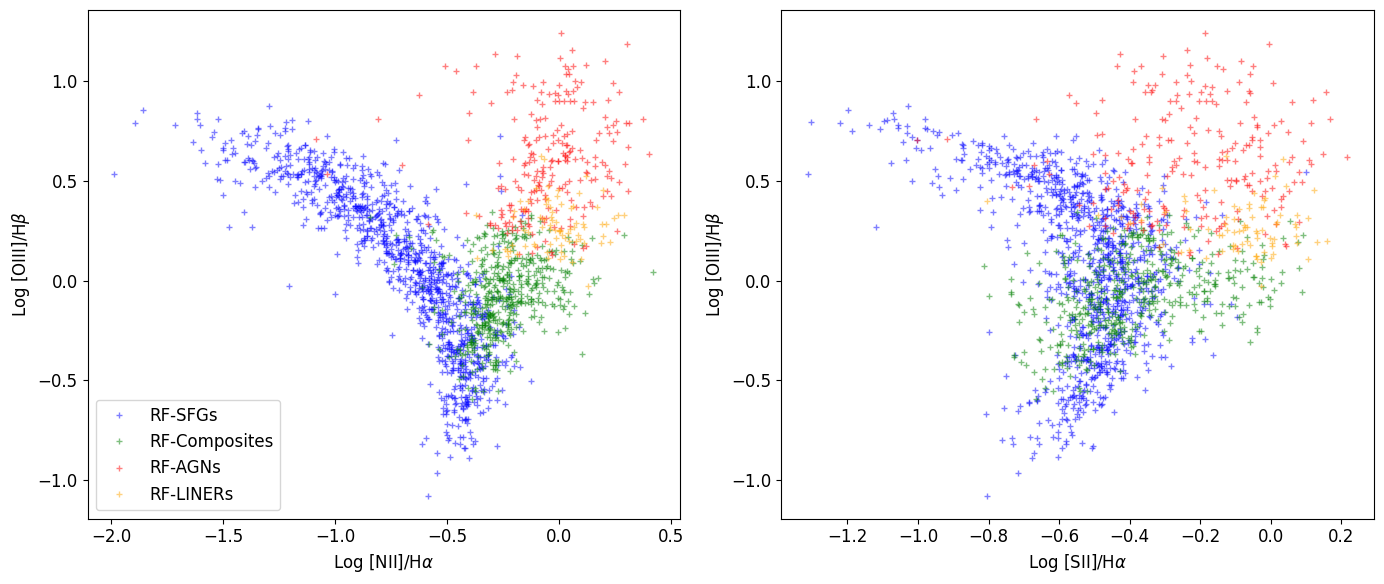

In [9]:
     
fig=plt.figure(num=1,figsize=(14,6))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

markersize=4
alpha=0.5
plt.subplot(1, 2, 1)
plt.plot(N2_index_test[ind_new_sf],O3_index_test[ind_new_sf],'b+',markersize=markersize,alpha=alpha,label='RF-SFGs')
plt.plot(N2_index_test[ind_new_comp],O3_index_test[ind_new_comp],'g+',markersize=markersize,alpha=alpha,label='RF-Composites')
plt.plot(N2_index_test[ind_new_AGN],O3_index_test[ind_new_AGN],'r+',markersize=markersize,alpha=alpha,label='RF-AGNs')
plt.plot(N2_index_test[ind_new_liner],O3_index_test[ind_new_liner],'+',color='orange',markersize=markersize,alpha=alpha,label='RF-LINERs')
plt.xlabel(r'Log [NII]/H$\alpha$')
plt.ylabel(r'Log [OIII]/H$\beta$')
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
plt.xlabel(r'Log [SII]/H$\alpha$')
plt.ylabel(r'Log [OIII]/H$\beta$')
plt.plot(S2_index_test[ind_new_sf],O3_index_test[ind_new_sf],'b+',markersize=markersize,alpha=alpha)
plt.plot(S2_index_test[ind_new_comp],O3_index_test[ind_new_comp],'g+',markersize=markersize,alpha=alpha)
plt.plot(S2_index_test[ind_new_AGN],O3_index_test[ind_new_AGN],'r+',markersize=markersize,alpha=alpha)
plt.plot(S2_index_test[ind_new_liner],O3_index_test[ind_new_liner],'+',color='orange',markersize=markersize,alpha=alpha)
fig.tight_layout()
plt.show()
#plt.savefig('new_bpt.pdf', format='pdf', dpi=1000)
plt.close()

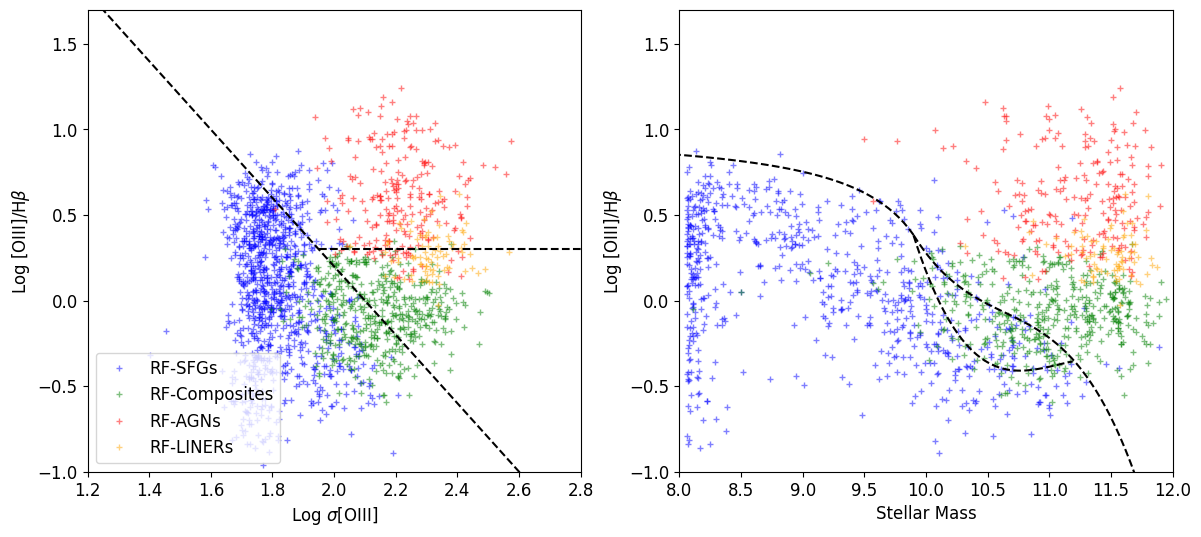

In [10]:
fig=plt.figure(num=1,figsize=(14,6))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

markersize=4
alpha=0.5
plt.subplot(1, 2, 1)
t=np.log10(np.sqrt((10**sigma_o3_test)**2-55**2))
plt.plot(t[ind_new_sf],O3_index_test[ind_new_sf],'b+',markersize=markersize,alpha=alpha,label='RF-SFGs')
plt.plot(t[ind_new_comp],O3_index_test[ind_new_comp],'g+',markersize=markersize,alpha=alpha,label='RF-Composites')
plt.plot(t[ind_new_AGN],O3_index_test[ind_new_AGN],'r+',markersize=markersize,alpha=alpha,label='RF-AGNs')
plt.plot(t[ind_new_liner],O3_index_test[ind_new_liner],'+',color='orange',markersize=markersize,alpha=alpha,label='RF-LINERs')
xx=np.arange(10)/5.+1.2
yy=-2*xx+4.2
xx2=np.arange(10)/5.+1.95
yy2=np.zeros(10)+0.3
plt.plot(xx,yy,linestyle='--',color='black')
plt.plot(xx2,yy2,linestyle='--',color='black')
plt.xlabel(r'Log $\sigma$[OIII]')
plt.ylabel(r'Log [OIII]/H$\beta$')
plt.axis([1.2,2.8,-1,1.7])
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
plt.plot(sm_test[ind_new_sf],O3_index_test[ind_new_sf],'b+',markersize=markersize,alpha=alpha,label='RF-SFGs')
plt.plot(sm_test[ind_new_comp],O3_index_test[ind_new_comp],'g+',markersize=markersize,alpha=alpha,label='RF-Composites')
plt.plot(sm_test[ind_new_AGN],O3_index_test[ind_new_AGN],'r+',markersize=markersize,alpha=alpha,label='RF-AGNs')
plt.plot(sm_test[ind_new_liner],O3_index_test[ind_new_liner],'+',color='orange',markersize=markersize,alpha=alpha,label='RF-LINERs')
xx0=8.0+np.arange(100)/25.
xx1=9.9-np.arange(100)/25.
xx2=9.9+np.arange(100)/25.
xx3=9.9+np.arange(130)/100.
yy1_lt=0.37/(xx1-10.5)+1
yy1_gt=594.753-167.074*xx2+15.6748*xx2**2-0.491215*xx2**3
yy2_gt=800.492-217.328*xx3+19.6431*xx3**2-0.591349*xx3**3
plt.plot(xx1,yy1_lt,linestyle='--',color='black')
plt.plot(xx2,yy1_gt,linestyle='--',color='black')
plt.plot(xx3,yy2_gt,linestyle='--',color='black')
plt.xlabel(r'Stellar Mass')
plt.ylabel(r'Log [OIII]/H$\beta$')
plt.axis([8,12,-1,1.7])
plt.show()
#plt.savefig('KEx-MEx.pdf', format='pdf', dpi=1000)
plt.close()
   

<Figure size 1200x900 with 0 Axes>

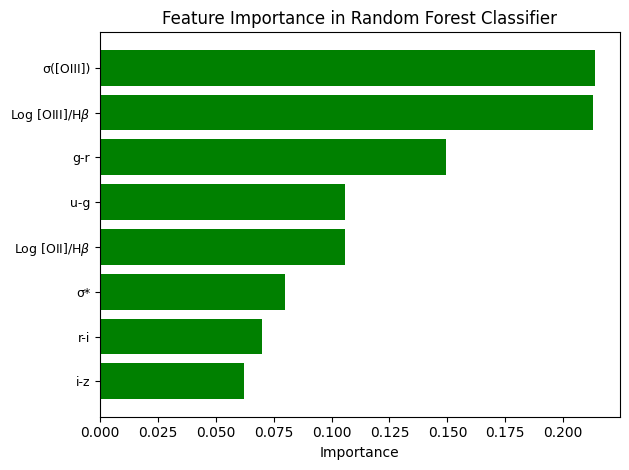

In [11]:
if title=='Random Forest Classifier':
    fig=plt.figure(0,figsize=(12,9))

    plt.rcdefaults()
    fig, ax = plt.subplots()
    if short == 'rf2':
        labels=[r'Log [OIII]/H$\beta$','\u03C3([OIII])']
    else:
        labels=[r'Log [OIII]/H$\beta$',r'Log [OII]/H$\beta$','\u03C3*','\u03C3([OIII])','u-g','g-r','r-i','i-z']
    y_pos = np.arange(len(labels))
    performance = clf.feature_importances_
    ind_sort=np.argsort(-performance)

    people = tuple(np.array(labels)[ind_sort])
    ax.barh(y_pos, performance[ind_sort], align='center',color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people,fontsize=9)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance in Random Forest Classifier')
    fig.tight_layout()
    plt.show()
    #plt.savefig(short+'_importance.pdf', format='pdf', dpi=1000)
    plt.close()

    

In [12]:
accuracy_overall=(accuracy_sf[:,0]+accuracy_comp[:,1]+accuracy_AGN[:,2]+accuracy_liner[:,3])/4.
print(accuracy_sf[:,0],accuracy_comp[:,1],accuracy_AGN[:,2],accuracy_liner[:,3],accuracy_overall)

alpha=0.5
fig=plt.figure(num=1,figsize=(14,6))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
fontsize=12
x00=0.03
y00=0.05
plt.subplot(121)
plt.plot(mark_points,accuracy_sf[:,0],'b',alpha=alpha)
plt.plot(mark_points,accuracy_sf[:,0],'b+',label="SFGs",alpha=alpha)
plt.plot(mark_points,accuracy_comp[:,1],'g',alpha=alpha)
plt.plot(mark_points,accuracy_comp[:,1],'gv',marker='v',label="Composites",alpha=alpha)
plt.plot(mark_points,accuracy_AGN[:,2],'r',alpha=alpha)
plt.plot(mark_points,accuracy_AGN[:,2],'rd',label="AGNs",alpha=alpha)
plt.plot(mark_points,accuracy_liner[:,3],color='orange',alpha=alpha)
plt.plot(mark_points,accuracy_liner[:,3],'x',color='orange',label="LINERs",alpha=alpha)
plt.plot(mark_points,accuracy_overall,'m',label="Overall",alpha=alpha)
plt.axis([0,mark_points[-1], 0, 1])
plt.xlabel('Training Sample Size')
plt.ylabel('Classification Accuracy')
plt.title(title)
plt.text(x00*n_round,y00,'(a)',fontsize=fontsize)
plt.legend(loc='lower right')



plt.subplot(122)
lw=2
label_arr=['SFGs','Composites','AGNs','LINERs']
colors = cycle(['blue', 'green', 'red','orange'])

if True:

    cv = StratifiedKFold(n_splits=6)
    j=0
    X=np.array(X)
    Y=np.array(Y)
    n_classes=4
    colors = ['blue', 'green', 'red','orange']
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train_s, test_s in cv.split(X, Y):
        probas_ = clf.fit(X[train_s], Y[train_s]).predict_proba(X[test_s])
        # save the model to disk
        filename = 'model_'+short+'_'+str(j)+'.sav'
        pickle.dump(clf, open(filename, 'wb'))

        # Compute ROC curve and area the curve
        for i in range(n_classes):
            label_temp=np.array(copy.deepcopy(Y[test_s]))
            indt1=np.where(label_temp == i+1)
            indt2=np.where(label_temp != i+1)
            label_temp[indt1]=1
            label_temp[indt2]=0
            fpr, tpr, _ = roc_curve(label_temp, probas_[:, i])  # Use prob
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            if j==0:
                label='ROC fold %d (AUC = %0.2f)' % (j, roc_auc)
            else:
                label=''
            plt.plot(fpr, tpr, lw=1, alpha=0.2, color=colors[i])
        j+=1
    tprs=np.array(tprs)
    aucs=np.array(aucs)
    ind_select=np.array([0,4,8,12,16])
    mean_tpr_sf = np.mean(tprs[ind_select], axis=0)
    mean_tpr_comp = np.mean(tprs[ind_select+1], axis=0)
    mean_tpr_AGN = np.mean(tprs[ind_select+2], axis=0)
    mean_tpr_liner = np.mean(tprs[ind_select+3], axis=0)

    mean_auc_sf = auc(mean_fpr, mean_tpr_sf)
    mean_auc_comp = auc(mean_fpr, mean_tpr_comp)
    mean_auc_AGN = auc(mean_fpr, mean_tpr_AGN)
    mean_auc_liner = auc(mean_fpr, mean_tpr_liner)

    std_auc_sf = np.std(aucs[ind_select])
    std_auc_comp = np.std(aucs[ind_select+1])
    std_auc_AGN = np.std(aucs[ind_select+2])
    std_auc_liner = np.std(aucs[ind_select+3])
    std_tpr_sf = np.std(tprs[ind_select], axis=0)
    std_tpr_comp = np.std(tprs[ind_select+1], axis=0)
    std_tpr_AGN = np.std(tprs[ind_select+2], axis=0)
    std_tpr_liner = np.std(tprs[ind_select+3], axis=0)

    tprs_sf_upper = np.minimum(mean_tpr_sf + std_tpr_sf, 1)
    tprs_sf_lower = np.maximum(mean_tpr_sf - std_tpr_sf, 0)
    tprs_comp_upper = np.minimum(mean_tpr_comp + std_tpr_comp, 1)
    tprs_comp_lower = np.maximum(mean_tpr_comp - std_tpr_comp, 0)
    tprs_AGN_upper = np.minimum(mean_tpr_AGN + std_tpr_AGN, 1)
    tprs_AGN_lower = np.maximum(mean_tpr_AGN - std_tpr_AGN, 0)
    tprs_liner_upper = np.minimum(mean_tpr_liner + std_tpr_liner, 1)
    tprs_liner_lower = np.maximum(mean_tpr_liner - std_tpr_liner, 0)

    plt.plot(mean_fpr, mean_tpr_sf, color=colors[0],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f) for SFGs' % (mean_auc_sf, std_auc_sf),lw=2, alpha=.8)
    plt.plot(mean_fpr, mean_tpr_comp, color=colors[1],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f) for Composites' % (mean_auc_comp, std_auc_comp),lw=2, alpha=.8)
    plt.plot(mean_fpr, mean_tpr_AGN, color=colors[2],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f) for AGNs' % (mean_auc_AGN, std_auc_AGN),lw=2, alpha=.8)
    plt.plot(mean_fpr, mean_tpr_liner, color=colors[3],label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f) for LINERs' % (mean_auc_liner, std_auc_liner),lw=2, alpha=.8)

    plt.fill_between(mean_fpr, tprs_sf_lower, tprs_sf_upper, color=colors[0], alpha=.2, label=r'$\pm$ 1$\sigma$ for SFGs')
    plt.fill_between(mean_fpr, tprs_comp_lower, tprs_comp_upper, color=colors[1], alpha=.2, label=r'$\pm$ 1$\sigma$ for Composites')
    plt.fill_between(mean_fpr, tprs_AGN_lower, tprs_AGN_upper, color=colors[2], alpha=.2, label=r'$\pm$ 1$\sigma$ for AGNs')
    plt.fill_between(mean_fpr, tprs_liner_lower, tprs_liner_upper, color=colors[3], alpha=.2, label=r'$\pm$ 1$\sigma$ for LINERs')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('ROC Curves of 4 types of ELGs using '+title)

fig.tight_layout()
plt.savefig(short+'_performance.pdf', format='pdf', dpi=1000)
plt.close()
outout={'mean_fpr':mean_fpr.tolist(),'mean_tpr_sf':mean_tpr_sf.tolist(), 'mean_tpr_comp':mean_tpr_comp.tolist(), 'mean_tpr_AGN':mean_tpr_AGN.tolist(),'mean_tpr_liner':mean_tpr_liner.tolist(),
        'tprs_sf_lower':tprs_sf_lower.tolist(),'tprs_comp_lower':tprs_comp_lower.tolist(),'tprs_AGN_lower':tprs_AGN_lower.tolist(),'tprs_liner_lower':tprs_liner_lower.tolist(),
         'tprs_sf_upper':tprs_sf_upper.tolist(),'tprs_comp_upper':tprs_comp_upper.tolist(),'tprs_AGN_upper':tprs_AGN_upper.tolist(),'tprs_liner_upper':tprs_liner_upper.tolist(), 
        'mean_auc_sf':mean_auc_sf,'mean_auc_comp':mean_auc_comp,'mean_auc_AGN':mean_auc_AGN,'mean_auc_liner':mean_auc_liner,
        'std_auc_sf':std_auc_sf,'std_auc_comp':std_auc_comp,'std_auc_AGN':std_auc_AGN,'std_auc_liner':std_auc_liner}

with open('roc_'+short+'.json', 'w') as outfile:  
    json.dump(outout, outfile)

accuracy_overall=(accuracy_sf[:,0]+accuracy_comp[:,1]+accuracy_AGN[:,2]+accuracy_liner[:,3])/4.
print(accuracy_sf[:,0],accuracy_comp[:,1],accuracy_AGN[:,2],accuracy_liner[:,3],accuracy_overall)
print(np.mean(accuracy_sf[-6:,0]),np.std(accuracy_sf[-6:,0]))
print(np.mean(accuracy_comp[-6:,1]),np.std(accuracy_comp[-6:,1]))
print(np.mean(accuracy_AGN[-6:,2]),np.std(accuracy_AGN[-6:,2]))
print(np.mean(accuracy_liner[-6:,3]),np.std(accuracy_liner[-6:,3]))

[0.91772772] [0.67025862] [0.63793103] [0.74074074] [0.74166453]


C:\Users\cstij\AppData\Local\Temp\ipykernel_124480\2733490899.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "gv" (-> marker='v'). The keyword argument will take precedence.
  plt.plot(mark_points,accuracy_comp[:,1],'gv',marker='v',label="Composites",alpha=alpha)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(

[0.91772772] [0.67025862] [0.63793103] [0.74074074] [0.74166453]
0.9177277179236043 0.0
0.6702586206896551 0.0
0.6379310344827587 0.0
0.7407407407407407 0.0
